In [1]:
#%pylab inline
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite, clustering, clique
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats
from scipy.stats import entropy
%matplotlib inline

# Assignment 1

Please, answer the question by entering runable python code into the cells. Add comments at the beginning of each cell which list the packages that need to be installed (e.g., pip install collections). Run the code so that the output is visible in the notbook before you submit. The data files which you download should lie in the same directory as the python notebooks (use relative paths!). Use python 3.


Submit the notebook (as .ipynb and .pdf) via email to clwagner@uni-koblenz.de until <font color="red">20.5.2016 (midnight ECT)</font>.
Subject of email: "CSS2016 ass 1"

Filename: firstname_lastname_ass1.ipynb 


## Analyzing Affiliation Networks and Social Networks (15 Points)

Download the following 2 datasets about the location-based social networking service Brightkite: http://snap.stanford.edu/data/loc-brightkite.html

One of the dataset contains all checkins between April 2008 and October 2010 (4.5 Mio checkins).

Beside the checkin data that constitute an affiliation network (two-mode network of users and locations), there is also a social network included  - i.e., a one-mode netowkr of users. It is an undirected one-mode network.



#### Location Popularity

Count the number of distinct brightkite users who checked-in at each location (using python!). What are the top 10 locations---i.e., the locations where most users checked in? Plot the rank ordered frequency distributions of locations (x-axis: locations ranked by the number of distinct users, y-axis: number of distinct users). <font color="red">(2 Points)</font>


In [2]:
df = pd.read_csv("Brightkite_totalCheckins.txt", delimiter="\t", header=None)
df.columns = ["userid", "timestamp", "long", "lat", "locid"]
df=df.drop(["timestamp", "long", "lat"], axis=1)

In [3]:
df_ = df.groupby("locid")
aggr = df_["userid"].agg({'unique_users': pd.Series.nunique, "all_checkings": np.count_nonzero}).sort_values("unique_users",  ascending=False )

In [4]:
## cutting long-tail
df1 = aggr[aggr.unique_users >= 80]['unique_users']
print(df1[:10])

locid
00000000000000000000000000000000    3204
ee81ef22a22411ddb5e97f082c799f59    1437
ede07eeea22411dda0ef53e233ec57ca    1199
ee8b1d0ea22411ddb074dbd65f1665cf     983
ee78cc1ca22411dd9b3d576115a846a7     846
eefadd1aa22411ddb0fd7f1c9c809c0c     811
d12e8e8aa22411dd90196fa5c210e3cc     779
b9d89b5ea22411dda5ef27ee20f87cee     728
ed58942aa22411dd96ff97a15c29d430     710
b9c114f2a22411dda217eb3127033598     576
Name: unique_users, dtype: int64


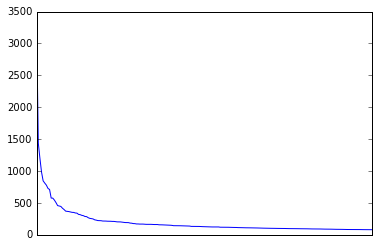

In [5]:
ax = df1.plot()
ax.axes.xaxis.set_visible(False)

#### Fold Location-User Network

Construct an unweighted and undirected two-mode network of brightkite users and locations. A user and a location are connected if the user checked-in at the location at least once. Compute the degree of each location in the two-mode network and list the top 10 location-ids with their corresponding degree. Make a plot that shows the ranked locations (x-axis) and their degree (y-axis).

Fold the two-mode network and construct a location network. Since folding the full network is very slow, select only locations where at least 10 users checked in.

What are the most central locations in the one-mode network and what does that mean? 
Use different centrality measures and order nodes by these centralities and print the top 10 nodes for each measure. Discuss for each centrality measure what it does and how you can interpret the results. For example, what does it mean that location X has the highest betweeness centrality? How is location X different from location Y which has the highest degree centrality?
<font color="red">(3 Points)</font>

In [6]:
df_no_dupl = df.drop_duplicates(['locid','userid'])

In [7]:
lid=list(set(df_no_dupl.locid.values))
uid=list(set(df_no_dupl.userid.values)) 

In [8]:
G=nx.Graph()
G.add_nodes_from(uid, bipartite=0)
G.add_nodes_from(lid, bipartite=1)
G.add_edges_from([tuple(x) for x in df_no_dupl.values])

In [9]:
X, Y = bipartite.sets(G)
degX,degY=bipartite.degrees(G,Y)
df_deegrees = pd.DataFrame(list(degY.items()), columns=['l','u']).sort_values(by='u', ascending=False).set_index(['l'])
df_degrees_without_tail = df_deegrees[df_deegrees.u >= max(df_deegrees.u)*0.04]

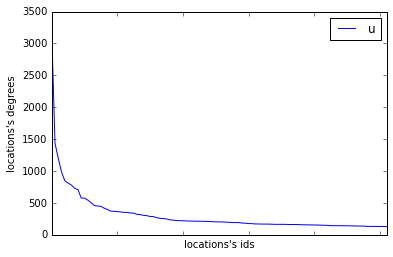

In [10]:
ax_degree = df_degrees_without_tail.plot()
plt.figure(); ax_degree.plot();
plt.setp(ax_degree.get_xticklabels(), visible=False) 
ax_degree.set_xlabel("locations's ids")
ax_degree.set_ylabel("locations's degrees")
plt.show()

In [11]:
to_keep = [n for n in degY if degY[n] > 20]

**Note** Unfortunately my laptop is too slow and doesn't perform next operations of folding and calculating centralities measured. Theoretically code should look as below 

In [ ]:
PG = bipartite.projected_graph(G, to_keep)

In [ ]:
d_cent = nx.degree_centrality(G2) #return dictionary

In [ ]:
clos_cent = nx.closeness_centrality(G2) #return dictionary

In [ ]:
bet_cent = nx.betweenness_centrality(G2) #return dictionary

In [ ]:
d_cent_top10 = dict(sorted(d_cent.items(), key=operator.itemgetter(1), reverse=True)[:10])#5 maximum values in a python dictionary
clos_cent_top10 = dict(sorted(clos_cent.items(), key=operator.itemgetter(1), reverse=True)[:10])#5 maximum values in a python dictionary
bet_cent_top10 = dict(sorted(bet_cent.items(), key=operator.itemgetter(1), reverse=True)[:10])#5 maximum values in a python dictionary

In [ ]:
print(d_cent_top10)
print(clos_cent_top10)
print(bet_cent_top10)

#### Answer for the question 
**Degree centrality**: if node has high number degree centrality, this node is involved in large number of interactions

**Closeness centrality**: if node has high number closeness centrality, this node is closer to the other nodes in the network.

**Betweenness centrality**: if node has high number betweenness centrality, it means this node will lie on a high proportion of paths between other nodes in the network.

Source: https://sites.google.com/site/networkanalysisacourse/schedule/an-introduction-to-centrality-measures

#### Entropy of Location Popularity Distribution

How evenly distributed is the attention of brightkite users towards locations? The attention a location receives is measured by the number of distinct users who checked in at this loction. Compute the normalized entropy of the degree distribution. The degree of a location corresponds to the number of distinct users who checked in there.

To that end, you want to have one vector where each element corresponds to a distinct location. The values for each element are then determined by the number of distinct users that have checked-in at that location. Then, calculate normalized entropy for this vector.

Assume we ignore all locations where 0-1 different people checked in. That means we make the long tail of the degree distribution shorter. How would the entropy change? <font color="red">(3 Points)</font>

In [33]:
list_degrees = df_deegrees['u'].tolist()

In [34]:
normalized_entropy_all = entropy(list_degrees, base=2)/np.log2(len(list_degrees))
print('normalized entropy for all deegrees: \t', normalized_entropy_all)
list_degree_cut_1 = [i for i in list_degrees if i>1]
normalized_entropy_cut_1 = entropy(list_degree_cut_1, base=2)/np.log2(len(list_degree_cut_1))
print('normalized entropy without deegrees < 1:', normalized_entropy_cut_1)
list_degree_cut_10 = [i for i in list_degrees if i>10]
normalized_entropy_cut_10 = entropy(list_degree_cut_10, base=2)/np.log2(len(list_degree_cut_10))
print('normalized entropy without deegrees < 10:', normalized_entropy_cut_10)
## e=1 maximally impure sample

normalized entropy for all deegrees: 	 0.966297796132
normalized entropy without deegrees < 1: 0.939014387234
normalized entropy without deegrees < 10: 0.924992865457


#### Answer to the question
The entropy is measure of impurity of distribution. We can see that if entropy is close to 1 it more heterogeneous. If we remove long tail from 1 entropy is slightly decreases for 0.03. However if we remove long tail till 10 it justfor 0.01. It says us that there are more nodes with degree 1 than nodes with degree from 1 to 10.

#### Describe Location Popularity Distribution

In how many distinct locations did users check in on average in brightkite? 
Create a boxplot that shows the distribution of the number of distinct checkin-locations per user. What is the mean and the variance of this distribution? Compute X for the following statement: Half of the users checked in in more than X locations?  <font color="red">(2 Points)</font>

In [35]:
df_user_deegrees = pd.DataFrame(list(degX.items()), columns=['u','l']).sort_values(by='l', ascending=False).set_index(['u'])
list_user_degrees = df_user_deegrees['l'].tolist()

In [37]:
print("Mean:     ", np.mean(list_user_degrees).round(2))
print("Median:   ", np.median(list_user_degrees))
print("Std dev:  ", np.std(list_user_degrees).round(2))
print("Variance: ", np.var(list_user_degrees).round(3))
state_frequencies = Counter(list_user_degrees)
print("Mode:     ", state_frequencies.most_common(1)[0][0])

Mean:      20.76
Median:    4.0
Std dev:   53.29
Variance:  2840.287
Mode:      1


In [38]:
percentile=np.percentile(list_user_degrees, 30)
percentile

2.0

**Answer to the question: **More than 30% of the users checked in in more than 2.0 locations

#### Analyzing the boxplots

It can be obsereved very long tail on the degree distribution. That is the reason why the first boxplot is hard to read. It only shows big numbers of outliers. I cut the data with high degree and take into account nodes with degree less than our mean. It helps to make the second boxplot more readable. Mean of the second boxplot around 2 and point between 25 and 75 percentiles lies in the range [1-6]

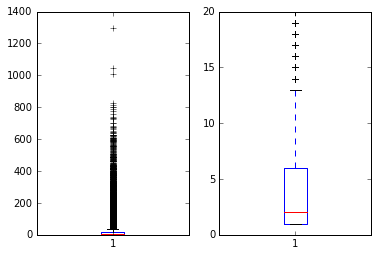

In [40]:
list_user_degrees_cut_1 = [i for i in list_user_degrees if i<20.7]

plt.figure(1)
plt.subplot(121)
plt.boxplot(list_user_degrees)

plt.subplot(122)
plt.boxplot(list_user_degrees_cut_1)
plt.show()

#### Describe Social Network

Load the full Brightkite social network (loc-brightkite_edges.txt.gz). Describe the network.

Some ideas on what you could report: What's the number of nodes, edges and average degree of a node?  What is the size of the largest maximal clique in the network? How well connected is the network? <font color="red">(2 Points)</font>

In [20]:
df_u = pd.read_table("Brightkite_edges.txt", names=['id_user1','id_user2'],header=None)# nrows=10500

In [21]:
nodes = list(np.unique(df_u[['id_user1', 'id_user2']].values))
GU = nx.Graph()
GU.add_nodes_from(nodes)
GU.add_edges_from([tuple(x) for x in df_u.values])

In [22]:
num_nodes = nx.number_of_nodes(GU)
num_edg2 = nx.number_of_edges(GU)

print('Number of nodes: ', num_nodes)
print('Number of edges: ', num_edg2)

Number of nodes:  58228
Number of edges:  214078


In [27]:
#diam = nx.diameter(GU)
#ecc = nx.eccentricity(GU)
#rad = nx.radius(GU)
mean_degree = sum(list(GU.degree().values()))/float(len(GU))
cc_GU = nx.clustering(GU)
avg_clust_GU = sum(list(cc_GU.values())) / len(cc_GU)
size_l_max_cliq_GU = nx.graph_clique_number(GU)
#print('ecc node[11]: ', ecc[10])
#print('diam: ', diam)
#print('rad: ', rad)
print('mean Degree: ', round(mean_degree, 2))
print('Average clustering coefficient: ', avg_clust_GU)
print('size of the largest maximal clique: ', size_l_max_cliq_GU)

mean Degree:  7.35
Average clustering coefficient:  0.17232592744613315
size of the largest maximal clique:  37


#### Draw Social Network

Select the top location (i.e., the location where most distinct brightkite user checked in) and filter the brightkite social network (i.e., Brightkite_edges.txt) so that it only contains users (nodes) which checked in at the top location.
Load this subpart of the social networks into python (using the NetworkX library)
Plot the sub-network in an appealing way. <font color="red">(3 Points)</font>

In [31]:
list_ids = aggr[aggr.unique_users >= 10]['unique_users'].index[0:10].tolist()
list_users_of_top = []
for i in range(len(list_ids)): 
    mask =  (df.locid == list_ids[i]) 
    list_users_of_top += df[mask]['userid'].tolist()
list_users_of_top = list(set(list_users_of_top))

In [32]:
GUA = nx.Graph()
GUA.add_nodes_from(list_users_of_top)
GUA.add_edges_from(df_u.values)
SGUA = GUA.subgraph(list_users_of_top)

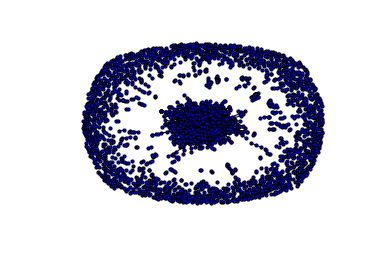

In [33]:
pos = nx.spring_layout(SGUA, iterations=25)
nx.draw_networkx_nodes(SGUA, pos, list_users_of_top, node_color='b', node_size=10)
nx.draw_networkx_edges(SGUA, pos)
plt.axis('off')
plt.show()